In [75]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [76]:
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [79]:
X = torch.arange(10).reshape((2, 5))# batch_size:2，num_steps = 5
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

# 从0开始实现
## 1.初始化模型参数
+ 可看做多分类问题，类别为词表对应词元

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#定义初始隐藏层状态
#当为特殊rnn，比如GRU,LSTM时隐状态包含多个变量
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

### 在一个时间步内计算隐状态和输出
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)#按照时间项拼接起来

## 2.循环神经网络模型

In [81]:

######### 包装，通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device): #初始隐状态生成
        return self.init_state(batch_size, self.num_hiddens, device)

In [82]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 3.定义预测函数

In [83]:
#不断地将隐状态传递到下一个时间步，不生成任何输出：预热（warm-up）期， 
#此期间模型会自我更新（例如，更新隐状态），预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，
#从而预测字符并输出它们。

# 定义预测函数来生成prefix之后的新字符
def predict(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [84]:
# 未训练时的预测
predict('time travellor ',10,net,vocab,device)

'time travellor iqdmcntlad'

## 4.梯度裁剪

In [42]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 5.训练

In [43]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [22]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.2, 45968.7 词元/秒 cuda
time travelleryou can show black is whice by noffreedot thay lod
travelleryou can show black is whice by noffreedot thay lod


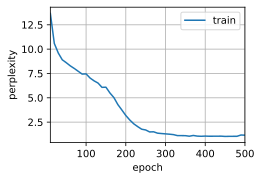

In [44]:
#使用顺序序列方法的结果
num_epochs, lr = 500, 1
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps,use_random_iter=False)
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

困惑度 1.6, 47041.5 词元/秒 cuda:0
time traveller smiled rrewcen three dimensions wo hand trick or 
traveller smiled round at us then still smiling faintlyand 


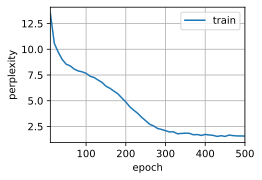

In [49]:
#使用随机抽样方法的结果
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps,use_random_iter=True)
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# RNN简单版本
+ 输出层需要自己定义

In [88]:
batch_size, num_steps = 32,35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab),num_hiddens)
state = torch.zeros((1, batch_size, num_hiddens))

X = torch.rand(size=(num_steps,batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
print(Y.shape, state_new.shape)

torch.Size([35, 32, 256]) torch.Size([1, 32, 256])


In [93]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer, vocab_size, **kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size# 输出长度
        self.num_hiddens = self.rnn.hidden_size # 隐藏层宽度
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)# 定义输出层
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens*2, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(),self.vocab_size)# torch long()：向下取整
        X = X.to(torch.float32)
        Y,state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1,Y.shape[-1])))
        return output, state
    
    def begin_state(self,device,batch_size=1): #初始隐状态
        '''self.rnn.num_layers:隐藏层层数'''
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,batch_size, 
                                self.num_hiddens), device = device)
        
        else:
            # nn.LSTM以元组作为隐状态,  #需要初始记忆和初始隐状态
            return (torch.zeros((self.num_directions*self.rnn.num_layers,batch_size,
                               self.num_hiddens),device = device), torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [105]:
##  定义预测函数
def predict_v1(prefix, num_preds, net, vocab ,device):
    state = net.begin_state(device)
    outputs = [vocab[prefix[0]]]#token对应的索引
    get_input = lambda: torch.tensor([outputs[-1]],device = device).reshape((1,1))
    for y in prefix: #预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))#取最大分类对应的类别
    return ''.join([vocab.idx_to_token[i] for i in outputs])

#不断地将隐状态传递到下一个时间步，不生成任何输出：预热（warm-up）期， 
#此期间模型会自我更新（例如，更新隐状态），预热期结束后，隐状态的值通常比刚开始的初始值更适合预测，
#从而预测字符并输出它们。

In [107]:
net = RNNModel(rnn_layer,len(vocab))
net = net.to(device)
predict_v1('time traveller', 10, net, vocab, device)

'ttime travellervfvqvfvqvf'

perplexity 1.3, 204181.1 tokens/sec on cuda
time traveller proceeded anyreal bad whirg to the fire sime arav
travellerstol shis aulutintavione fight ang thet wain a our


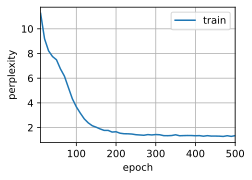

In [125]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# GRU
### 1.从零开始

In [143]:
## 定义GRU需要的所有参数
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size = shape, device=device)*0.01
    
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device = device))
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() #候选隐状态
    
    #输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#定义初始隐状态
def init_gru_state(batch_size, num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device = device),)

def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz + H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr + H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh + (R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda # 更新隐状态
        Y = H @ W_hq + b_q # 定义输出层
        outputs.append(Y)
    return torch.cat(outputs,dim=0), (H,) #输出， 隐状态
    

perplexity 1.1, 32197.3 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


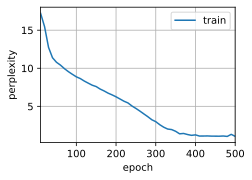

In [144]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params,init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 2.简介实现

perplexity 1.0, 103229.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


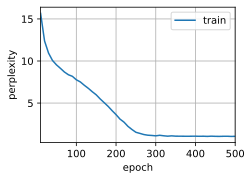

In [146]:
num_inputs = len(vocab)
num_hiddens = 256
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr,num_epochs, device)

# LSTM
### 1.从零开始实现

In [149]:
## 定义GRU需要的所有参数
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size = shape, device=device)*0.01
    
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device = device))
    
    W_xi, W_hi, b_i = three() # 输入门
    W_xf, W_hf, b_f = three() # 遗忘门
    W_xo, W_ho, b_o = three() # 输出门
    W_xc, W_hc, b_c = three() # 候选记忆
    
    #定义输出层
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device = device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
                       
#定义初始隐状态
def init_lstm_state(batch_size, num_hiddens,device):
    # 返回 初始隐状态H 和 记忆C
    return (torch.zeros((batch_size,num_hiddens),device = device),
            torch.zeros((batch_size,num_hiddens),device = device))

## 定义lstm网络
def lstm(inputs, state, params):
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,b_c, W_hq, b_q = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid(X @ W_xi + H @ W_hi + b_i)
        F = torch.sigmoid(X @ W_xf + H @ W_hf + b_f)
        O = torch.sigmoid(X @ W_xo + H @ W_ho + b_o)
        C_tilda = torch.tanh(X @ W_xc + H @ W_hc + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,C)

perplexity 1.1, 26577.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
traveller for the propicication lofithts cofupm the verinit


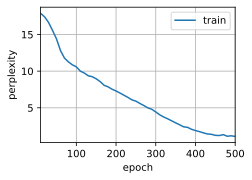

In [150]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 2.简单实现lstm

perplexity 1.3, 230521.3 tokens/sec on cuda:0
time traveller with a slight accession of heennot exfothanivet a
traveller with a slight accession of heennot exfothanithin 


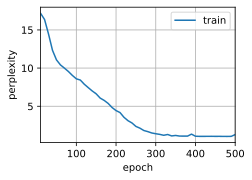

In [153]:
lstm_layer = nn.LSTM(len(vocab), num_hiddens)
net = RNNModel(lstm_layer,len(vocab))
net = net.to(device)
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 深度循环神经网络

perplexity 1.0, 136120.5 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


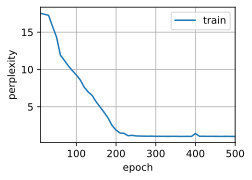

In [154]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2

lstm_layer = nn.LSTM(vocab_size, num_hiddens, num_layers)## 定义两层lstm
model = RNNModel(lstm_layer, vocab_size)
model = model.to(device)

num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr * 1.0, num_epochs, device)

# 双向RNN
+ 使用了过去的和未来的数据，不可以用作预测，可以填充缺失的单词、词元注释、对序列进行编码（例如，用于机器翻译）

perplexity 1.1, 20669.9 tokens/sec on cuda:0
time travellerererererererererererererererererererererererererer
travellerererererererererererererererererererererererererer


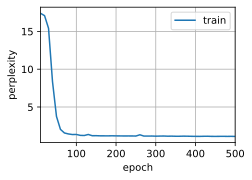

In [156]:
#### 错误示范，不可以用作预测
lstm_layer = nn.LSTM(vocab_size, num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
# 训练模型
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)